<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

Cloning into 'TSAI-EVA40-Assignments'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 730 (delta 156), reused 128 (delta 40), pack-reused 432
Receiving objects: 100% (730/730), 24.82 MiB | 18.77 MiB/s, done.
Resolving deltas: 100% (380/380), done.


In [0]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy

In [3]:
transform_params = dict()
transform_params['train'] = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),  
                                       transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),  
                                       transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
                                       transforms.ToTensor(),
                                       Cutout(n_holes=1, length=16,prob = 0.5),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform_params['test'] = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader,testloader = cifar_data_loader(transform_params,BatchSize=250)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


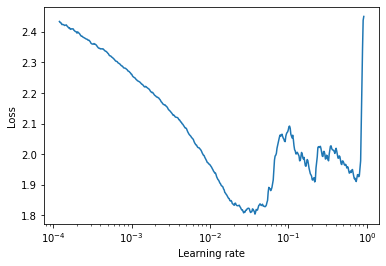

In [5]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()

In [6]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.021, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.8072196245193481 Batch_id=199 Accuracy=24.36: 100%|██████████| 200/200 [00:39<00:00,  5.02it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -1.4434, Accuracy: 3653/10000 (36.53%)

EPOCH: 1


Loss=1.6386955976486206 Batch_id=199 Accuracy=37.07: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -2.2662, Accuracy: 4185/10000 (41.85%)

EPOCH: 2


Loss=1.471219778060913 Batch_id=199 Accuracy=44.46: 100%|██████████| 200/200 [00:39<00:00,  5.05it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -2.8151, Accuracy: 4821/10000 (48.21%)

EPOCH: 3


Loss=1.3262020349502563 Batch_id=199 Accuracy=50.38: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -3.2314, Accuracy: 5532/10000 (55.32%)

EPOCH: 4


Loss=1.1251378059387207 Batch_id=199 Accuracy=54.81: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -3.9566, Accuracy: 5748/10000 (57.48%)

EPOCH: 5


Loss=1.118868350982666 Batch_id=199 Accuracy=58.86: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.2616, Accuracy: 6481/10000 (64.81%)

EPOCH: 6


Loss=0.8873776197433472 Batch_id=199 Accuracy=62.43: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.8262, Accuracy: 6806/10000 (68.06%)

EPOCH: 7


Loss=0.9102141857147217 Batch_id=199 Accuracy=64.78: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.0909, Accuracy: 6980/10000 (69.80%)

EPOCH: 8


Loss=0.8354126214981079 Batch_id=199 Accuracy=66.76: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.2168, Accuracy: 7160/10000 (71.60%)

EPOCH: 9


Loss=0.8675879836082458 Batch_id=199 Accuracy=68.57: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.2120, Accuracy: 7304/10000 (73.04%)

EPOCH: 10


Loss=0.9005014896392822 Batch_id=199 Accuracy=70.40: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.4783, Accuracy: 7422/10000 (74.22%)

EPOCH: 11


Loss=0.8114324808120728 Batch_id=199 Accuracy=71.86: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.8910, Accuracy: 7479/10000 (74.79%)

EPOCH: 12


Loss=0.8298141956329346 Batch_id=199 Accuracy=73.50: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.1367, Accuracy: 7623/10000 (76.23%)

EPOCH: 13


Loss=0.6681647300720215 Batch_id=199 Accuracy=74.54: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.5834, Accuracy: 7938/10000 (79.38%)

EPOCH: 14


Loss=0.6766632199287415 Batch_id=199 Accuracy=76.07: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.4169, Accuracy: 7656/10000 (76.56%)

EPOCH: 15


Loss=0.642471194267273 Batch_id=199 Accuracy=77.22: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.9732, Accuracy: 8053/10000 (80.53%)

EPOCH: 16


Loss=0.7223634719848633 Batch_id=199 Accuracy=77.83: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.2415, Accuracy: 8125/10000 (81.25%)

EPOCH: 17


Loss=0.6988817453384399 Batch_id=199 Accuracy=78.78: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.3312, Accuracy: 8138/10000 (81.38%)

EPOCH: 18


Loss=0.6067366003990173 Batch_id=199 Accuracy=79.69: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.4703, Accuracy: 8086/10000 (80.86%)

EPOCH: 19


Loss=0.4971733093261719 Batch_id=199 Accuracy=80.44: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.5835, Accuracy: 8259/10000 (82.59%)

EPOCH: 20


Loss=0.6020196676254272 Batch_id=199 Accuracy=81.11: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.6391, Accuracy: 8372/10000 (83.72%)

EPOCH: 21


Loss=0.5716982483863831 Batch_id=199 Accuracy=81.91: 100%|██████████| 200/200 [00:40<00:00,  4.94it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.0236, Accuracy: 8385/10000 (83.85%)

EPOCH: 22


Loss=0.41324105858802795 Batch_id=199 Accuracy=82.34: 100%|██████████| 200/200 [00:41<00:00,  4.85it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.8699, Accuracy: 8258/10000 (82.58%)

EPOCH: 23


Loss=0.5251843333244324 Batch_id=199 Accuracy=82.91: 100%|██████████| 200/200 [00:39<00:00,  5.00it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4111, Accuracy: 8525/10000 (85.25%)

EPOCH: 24


Loss=0.49755188822746277 Batch_id=199 Accuracy=83.37: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3648, Accuracy: 8589/10000 (85.89%)

EPOCH: 25


Loss=0.37907350063323975 Batch_id=199 Accuracy=83.83: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3661, Accuracy: 8462/10000 (84.62%)

EPOCH: 26


Loss=0.4817003309726715 Batch_id=199 Accuracy=84.24: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4379, Accuracy: 8546/10000 (85.46%)

EPOCH: 27


Loss=0.3241778016090393 Batch_id=199 Accuracy=84.73: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.5137, Accuracy: 8526/10000 (85.26%)

EPOCH: 28


Loss=0.4378024935722351 Batch_id=199 Accuracy=85.06: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.5289, Accuracy: 8698/10000 (86.98%)

EPOCH: 29


Loss=0.4826624393463135 Batch_id=199 Accuracy=85.66: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.7670, Accuracy: 8648/10000 (86.48%)

EPOCH: 30


Loss=0.41731327772140503 Batch_id=199 Accuracy=86.04: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1238, Accuracy: 8659/10000 (86.59%)

EPOCH: 31


Loss=0.40820321440696716 Batch_id=199 Accuracy=86.09: 100%|██████████| 200/200 [00:40<00:00,  5.00it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0039, Accuracy: 8670/10000 (86.70%)

EPOCH: 32


Loss=0.381831556558609 Batch_id=199 Accuracy=86.67: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1377, Accuracy: 8681/10000 (86.81%)

EPOCH: 33


Loss=0.35751694440841675 Batch_id=199 Accuracy=86.99: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1070, Accuracy: 8770/10000 (87.70%)

EPOCH: 34


Loss=0.3156049847602844 Batch_id=199 Accuracy=87.04: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3047, Accuracy: 8731/10000 (87.31%)

EPOCH: 35


Loss=0.3062817454338074 Batch_id=199 Accuracy=87.62: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1275, Accuracy: 8746/10000 (87.46%)

EPOCH: 36


Loss=0.3210274875164032 Batch_id=199 Accuracy=87.75: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.6127, Accuracy: 8765/10000 (87.65%)

EPOCH: 37


Loss=0.3291671872138977 Batch_id=199 Accuracy=88.29: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0917, Accuracy: 8824/10000 (88.24%)

EPOCH: 38


Loss=0.24969570338726044 Batch_id=199 Accuracy=88.47: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5570, Accuracy: 8792/10000 (87.92%)

EPOCH: 39


Loss=0.3200400769710541 Batch_id=199 Accuracy=88.71: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]



Test set: Average loss: -9.3478, Accuracy: 8707/10000 (87.07%)

Finished Training


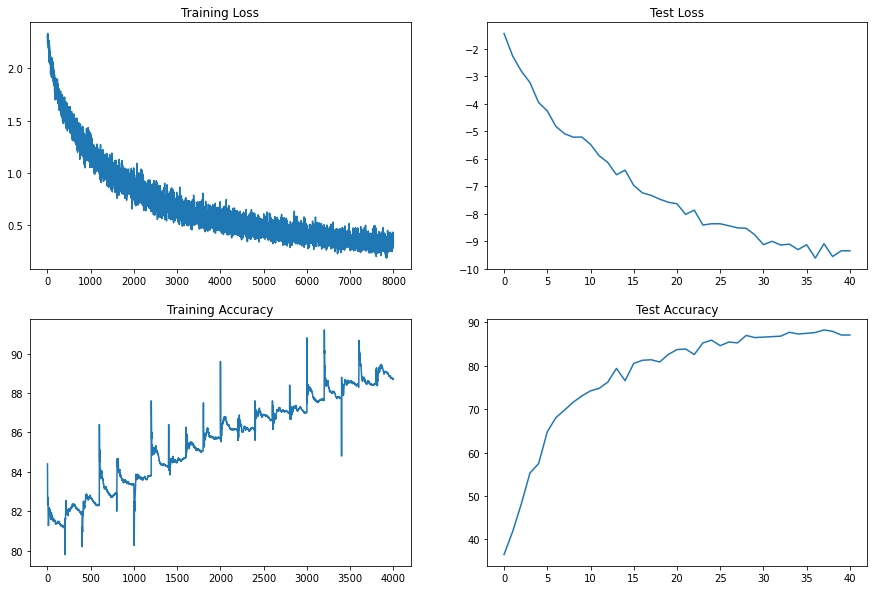

In [9]:
PlotTrainingGraphs(tt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

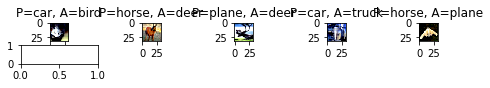

In [10]:
Misclassification(testloader,net,classes,device)

In [14]:
from gradcam import GradCamDisplay
import PIL
img_name =['airplane.png','automobile.png','bird.png','cat.png','deer.png']

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

FileNotFoundError: ignored

TypeError: ignored

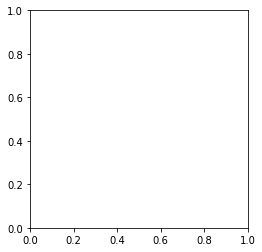

In [16]:
from pylab import *
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
images[:4]

tensor([[[[-1.8307, -1.8307, -1.8307,  ..., -1.8307, -1.8307, -1.8307],
          [-1.8307, -1.8307, -1.8307,  ..., -1.8307, -1.8307, -1.8307],
          [-1.8307, -1.8307, -1.8307,  ..., -1.8307, -1.8307, -1.8307],
          ...,
          [-1.8307, -1.8307, -1.8307,  ..., -1.8307, -1.8307, -1.8307],
          [-1.8307, -1.8307, -1.8307,  ..., -1.8307, -1.8307, -1.8307],
          [-1.8307, -1.8307, -1.8307,  ..., -1.8307, -1.8307, -1.8307]],

         [[-1.8230, -1.8230, -1.8230,  ..., -1.8230, -1.8230, -1.8230],
          [-1.8230, -1.8230, -1.8230,  ..., -1.8230, -1.8230, -1.8230],
          [-1.8230, -1.8230, -1.8230,  ..., -1.8230, -1.8230, -1.8230],
          ...,
          [-1.8230, -1.8230, -1.8230,  ..., -1.8230, -1.8230, -1.8230],
          [-1.8230, -1.8230, -1.8230,  ..., -1.8230, -1.8230, -1.8230],
          [-1.8230, -1.8230, -1.8230,  ..., -1.8230, -1.8230, -1.8230]],

         [[-1.5605, -1.5605, -1.5605,  ..., -1.5605, -1.5605, -1.5605],
          [-1.5605, -1.5605, -